### First Assignment 3

## Regression task

For this task we selected the *100,000 UK Used Car Data set* from Kaggle.  
The dataset comes in several files - by manufacturer.  
Two of the manufacturers had missing columns.  We decided not to include them.

In [32]:
# Import general use packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from zipfile import ZipFile
import requests
import seaborn as sns

In [33]:
# This block of code is for running the notebook in Google Colab
#from google.colab import files
#files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
import kaggle
kaggle.api.authenticate()

mkdir: /Users/raneensafadi/.kaggle: File exists
cp: kaggle.json: No such file or directory


In [34]:
# Download the dataset
! kaggle datasets download -d adityadesai13/used-car-dataset-ford-and-mercedes

used-car-dataset-ford-and-mercedes.zip: Skipping, found more recently modified local copy (use --force to force download)


In [35]:
# Read the data
col_names = ['model', 'year', 'price', 'transmission', 'milage', 'fuel_type', 'tax', 'mpg', 'engine_size']
datasets = []
with ZipFile('/Users/raneensafadi/used-car-dataset-ford-and-mercedes.zip') as zf:
  for file in zf.namelist():
    manufacturer = file.split('.')[0]
    if 'focus' in manufacturer or 'cclass' in manufacturer:
      continue
    
    datasets.append(pd.read_csv(zf.open(file), header=None, names=col_names, skiprows=1).dropna(how='all'))
    datasets[-1].loc[:, 'manufacturer'] = manufacturer

raw_dataset = pd.concat(datasets, ignore_index=True)

In [36]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99187 entries, 0 to 99186
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         99187 non-null  object 
 1   year          99187 non-null  int64  
 2   price         99187 non-null  int64  
 3   transmission  99187 non-null  object 
 4   milage        99187 non-null  int64  
 5   fuel_type     99187 non-null  object 
 6   tax           99187 non-null  int64  
 7   mpg           99187 non-null  float64
 8   engine_size   99187 non-null  float64
 9   manufacturer  99187 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 7.6+ MB


In [37]:
raw_dataset.head()

,model,year,price,transmission,milage,fuel_type,tax,mpg,engine_size,manufacturer
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4,audi
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0,audi
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4,audi
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0,audi
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0,audi


In [38]:
# Look at the categorical variables
raw_dataset[['model', 'year', 'transmission', 'fuel_type', 'manufacturer']].describe()

,year
count,99187.000000
mean,2017.087723
std,2.123934
min,1970.000000
25%,2016.000000
50%,2017.000000
75%,2019.000000
max,2060.000000


Let's look at the price column - the predicted variable

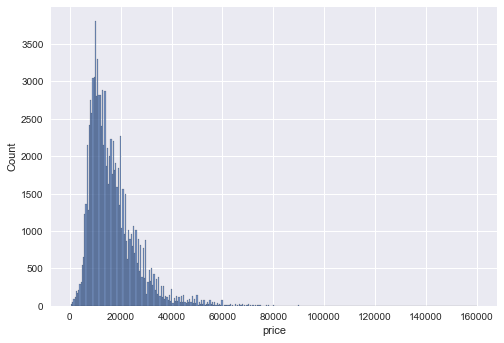

In [39]:
sns.histplot(raw_dataset.price);

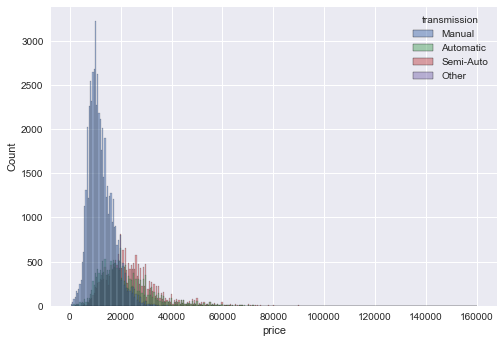

In [40]:
# Histogram by transmission
sns.histplot(raw_dataset, x='price', hue='transmission');

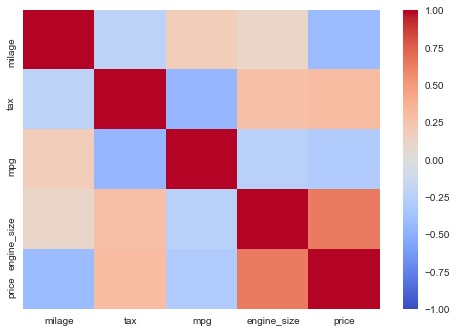

In [41]:
# Heatmap of the numerical variables, including price
sns.heatmap(raw_dataset[['milage', 'tax', 'mpg', 'engine_size', 'price']].corr(), cmap='coolwarm', vmin=-1, vmax=1);

### Data Preprocessing

We need to encode the categorical variables.  
For `transmission`, `fuel_type`, and `manufacturer` we'll use One-Hot encoding.  
For `model` we'll use Ordinal encoding.

In [ ]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
transmission = pd.get_dummies(raw_dataset.transmission)
fuel_type = pd.get_dummies(raw_dataset.fuel_type)
manufacturer = pd.get_dummies(raw_dataset.manufacturer)
model = pd.Series(OrdinalEncoder().fit_transform(raw_dataset[['model']]).flatten()).rename('model')

encoded_data = pd.concat([
  raw_dataset[['year', 'milage', 'mpg', 'engine_size', 'price']], 
  transmission.iloc[:, :-1], 
  fuel_type.iloc[:, :-1], 
  manufacturer.iloc[:, :-1], 
  model], axis=1)

In [ ]:
encoded_data.head()

### Building the model

In [ ]:
X, y = encoded_data.drop(columns='price'), encoded_data[['price']]

In [ ]:
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

First, we'll fit a simple Linear Regression model

In [ ]:
# Fit the model
model_1 = LinearRegression().fit(X_train, y_train)

In [ ]:
model_1.score(X_test, y_test)

0.7648936383398651

In [ ]:
# Get test predictions
model_1_pred = model_1.predict(X_test)

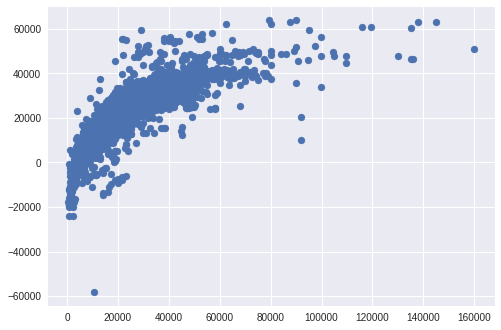

In [ ]:
# Plot the predictions vs real values
plt.scatter(y_test, model_1_pred.flatten())

We've seen that the distribution of the price column is skewed - has a long right tail.  
Since Linear Regression prefers normally distributed dependant variable, we'll apply a log transformation on the price.

In [ ]:
# Apply the transformation
y_log = y.apply(np.log)

In [ ]:
# re split the data into train and test sets
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, random_state=42) 

In [ ]:
# Fit the model
model_2 = LinearRegression().fit(X_train, y_train_log)

In [ ]:
model_2.score(X_test, y_test_log)

0.8781242377907783

In [ ]:
# Get the predictions
model_2_pred = model_2.predict(X_test)

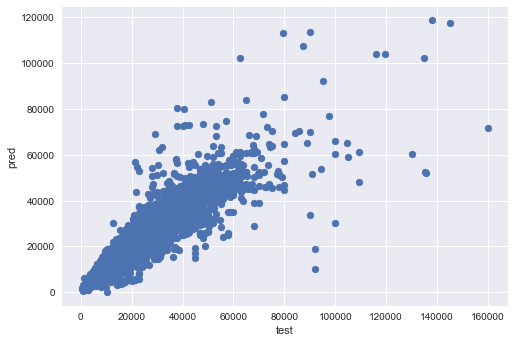

In [65]:
import matplotlib.pyplot as plt
plt.scatter(y_test, np.exp(model_2_pred).flatten())
plt.xlabel('test')
plt.ylabel('pred')
plt.show()

## Classification task

For this task we selected the *Heart Failure Prediction Dataset* from Kaggle.  
This is a binary classification problem.

In [ ]:
# Import general use packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from zipfile import ZipFile
import requests
import seaborn as sns
import kaggle
kaggle.api.authenticate()

In [ ]:
# Download the dataset
! kaggle datasets download -d fedesoriano/heart-failure-prediction -p heart-failure

  0% 0.00/8.56k [00:00<?, ?B/s]
100% 8.56k/8.56k [00:00<00:00, 3.67MB/s]


In [ ]:
from google.colab import files

In [70]:
raw_dataset = pd.read_csv('/Users/raneensafadi/Final project semester A/heart-failure/heart-failure-prediction.zip')

In [71]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [72]:
raw_dataset.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
raw_dataset[['ChestPainType', 'RestingECG', 'ST_Slope']].describe()

,ChestPainType,RestingECG,ST_Slope
count,918,918,918
unique,4,3,3
top,ASY,Normal,Flat
freq,496,552,460


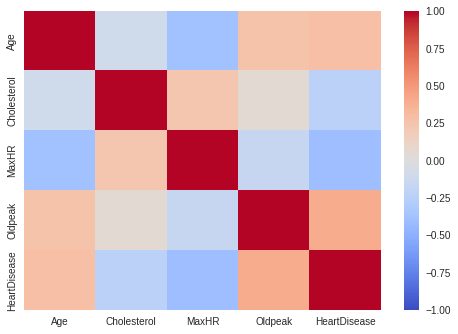

In [ ]:
# Heatmap of the numerical variables, including price
sns.heatmap(raw_dataset[['Age', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease']].corr(), vmin=-1, vmax=1, cmap='coolwarm');

### Data Preprocessing

In [73]:
ChestPainType = pd.get_dummies(raw_dataset.ChestPainType)
RestingECG = pd.get_dummies(raw_dataset.RestingECG)
ST_Slope = pd.get_dummies(raw_dataset.ST_Slope)
sex = (raw_dataset.Sex == 'F').astype(int)
ExerciseAngina = (raw_dataset.ExerciseAngina == 'Y').astype(int)

encoded_data = pd.concat([
  raw_dataset[['Age', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease', 'FastingBS']], 
  ChestPainType.iloc[:, :-1], 
  RestingECG.iloc[:, :-1], 
  ST_Slope.iloc[:, :-1], 
  sex,
  ExerciseAngina], axis=1)

In [74]:
encoded_data.head()

,Age,Cholesterol,MaxHR,Oldpeak,HeartDisease,FastingBS,ASY,ATA,NAP,LVH,Normal,Down,Flat,Sex,ExerciseAngina
0,40,289,172,0.0,0,0,0,1,0,0,1,0,0,0,0
1,49,180,156,1.0,1,0,0,0,1,0,1,0,1,1,0
2,37,283,98,0.0,0,0,0,1,0,0,0,0,0,0,0
3,48,214,108,1.5,1,0,1,0,0,0,1,0,1,1,1
4,54,195,122,0.0,0,0,0,0,1,0,1,0,0,0,0


### Fitting the KNN model

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [76]:
X, y = encoded_data.drop(columns='HeartDisease'), encoded_data[['HeartDisease']].squeeze()

In [77]:
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

In [78]:
model_1 = KNeighborsClassifier().fit(X_train, y_train)

In [79]:
model_1_pred = model_1.predict(X_test)

In [80]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve

In [81]:
model_1.score(X_train, y_train)

0.7906976744186046

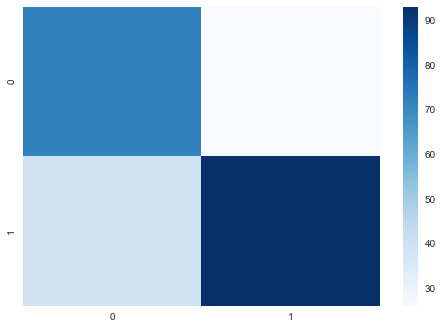

In [82]:
# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, model_1_pred), cmap='Blues');

Test different values of neighbors

In [83]:
k_values = [*range(3, 30, 2)] + [*range(30, 70, 5)]
models = []

for k in k_values:
  models.append(KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train))

In [84]:
accuracy_scores = [model.score(X_test, y_test) for model in models]

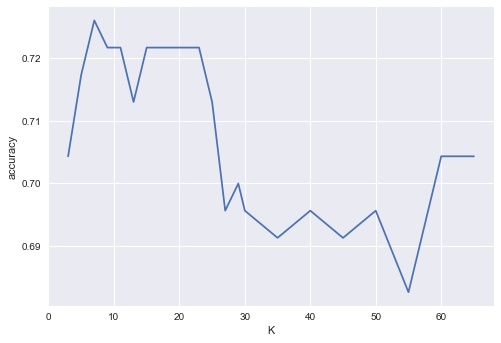

In [85]:
plt.plot(k_values, accuracy_scores)
plt.xlabel('K')
plt.ylabel('accuracy')
plt.show()

Looks like the default value of 5 is good enough

In [86]:
f1_score(y_test, model_1_pred)

0.7410358565737052

Let's test how the model improves when we scale the data

In [87]:
from sklearn.preprocessing import MinMaxScaler

In [88]:
scaled_features = pd.DataFrame(MinMaxScaler().fit_transform(X[['Age', 'Cholesterol', 'MaxHR', 'Oldpeak']]), columns=['Age', 'Cholesterol', 'MaxHR', 'Oldpeak'])
X_scaled = pd.concat([scaled_features, X.drop(columns=['Age', 'Cholesterol', 'MaxHR', 'Oldpeak'])], axis=1)

In [89]:
X_scaled.head()

,Age,Cholesterol,MaxHR,Oldpeak,FastingBS,ASY,ATA,NAP,LVH,Normal,Down,Flat,Sex,ExerciseAngina
0,0.244898,0.479270,0.788732,0.295455,0,0,1,0,0,1,0,0,0,0
1,0.428571,0.298507,0.676056,0.409091,0,0,0,1,0,1,0,1,1,0
2,0.183673,0.469320,0.267606,0.295455,0,0,1,0,0,0,0,0,0,0
3,0.408163,0.354892,0.338028,0.465909,0,1,0,0,0,1,0,1,1,1
4,0.530612,0.323383,0.436620,0.295455,0,0,0,1,0,1,0,0,0,0


In [90]:
# split the data into train and test sets
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, random_state=42) 

In [91]:
model_2 = KNeighborsClassifier().fit(X_train_scaled, y_train)

In [92]:
model_2_pred = model_1.predict(X_test_scaled)

In [93]:
model_2.score(X_test_scaled, y_test)

0.8521739130434782

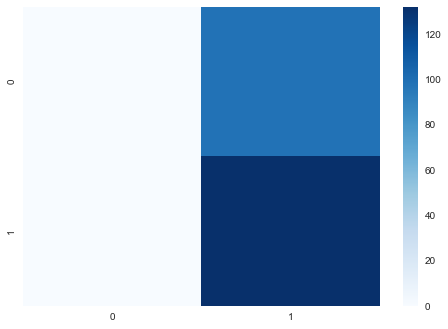

In [94]:
sns.heatmap(confusion_matrix(y_test, model_2_pred), cmap='Blues');

In [95]:
k_values = [*range(3, 30, 2)] + [*range(30, 70, 5)]
models = []

for k in k_values:
  models.append(KNeighborsClassifier(n_neighbors=k).fit(X_train_scaled, y_train))

In [96]:
accuracy_scores = [model.score(X_test_scaled, y_test) for model in models]

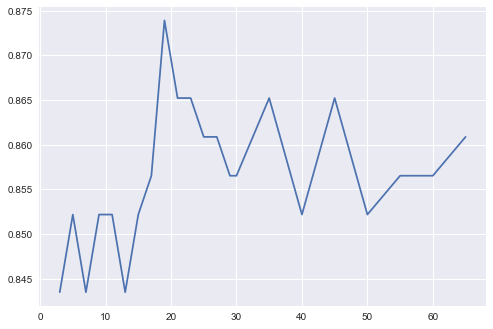

In [97]:
plt.plot(k_values, accuracy_scores);

According to the graph above, we can further improve the model by selecting `n_neighbors = 19`

In [98]:
best_knn = KNeighborsClassifier(n_neighbors=19).fit(X_train_scaled, y_train)

In [99]:
best_knn.score(X_test_scaled, y_test)

0.8739130434782608

In [100]:
best_knn_pred = best_knn.predict(X_test_scaled)